In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for TTVs in TIC 3224605

- Some suspicion that S86 dip is a tad early

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 3224605

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 19,2019,TESS-SPOC,1800,3224605,0.0,N/A
1,TESS Sector 43,2021,SPOC,120,3224605,0.0,"G04195 , G04231"
2,TESS Sector 44,2021,SPOC,120,3224605,0.0,"G04195 , G04231"
3,TESS Sector 45,2021,SPOC,120,3224605,0.0,"G04195 , G04231"
4,TESS Sector 59,2022,SPOC,120,3224605,0.0,N/A
5,TESS Sector 71,2023,SPOC,120,3224605,0.0,"G06148 , G06032"
6,TESS Sector 73,2023,SPOC,120,3224605,0.0,"G06148 , G06032"
7,TESS Sector 86,2024,SPOC,120,3224605,0.0,G07109


123389

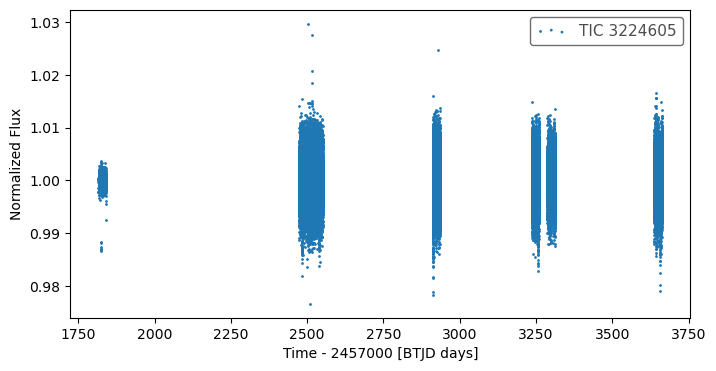

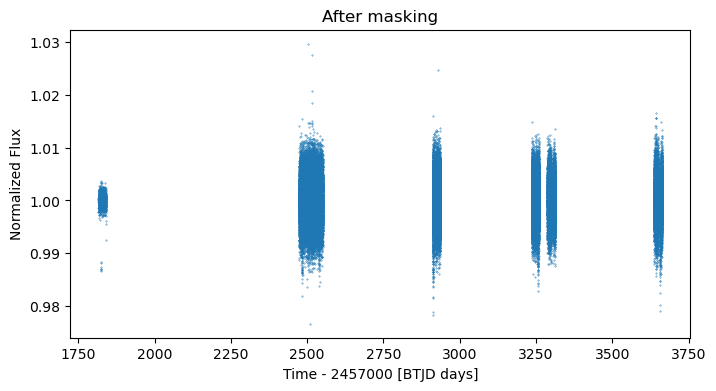

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

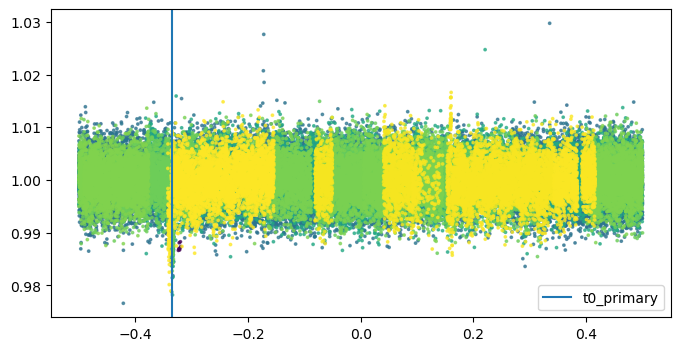

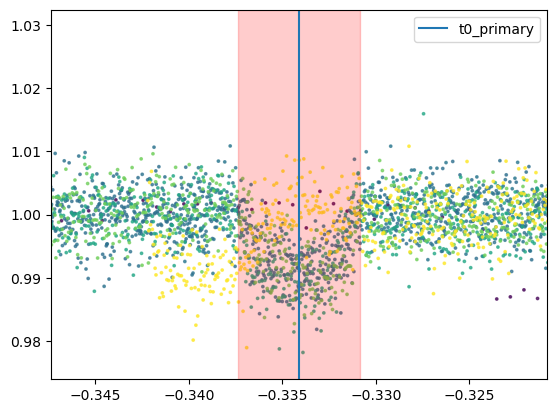

In [56]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# epoch=2483.0033, duration_hr=4.4802, period=28.650341, label="TOI 5552.01", transit_depth_percent=0.9472,  # period_error=0.00010813339
# MCMC on df_primary: 7.146093281667767

# FILL-IN THE eclipse epoch / period,
period = 28.6503  # TOI, error ~=0.0001, doesn't fit well for S86 dip and S19 dip (way off). /The ETV codes somehow didn't get S86 dip
t0_primary = 2483.0033  # TOI

# period = 28.6425  # manual to fit S19 + S86, but way off for ohter dips
# t0_primary = 1824.41  # manual to fit S19 + S86

t0_secondary = None

duration_hr_primary = 4.48
duration_hr_secondary = None

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.01, t4_p + 0.01);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

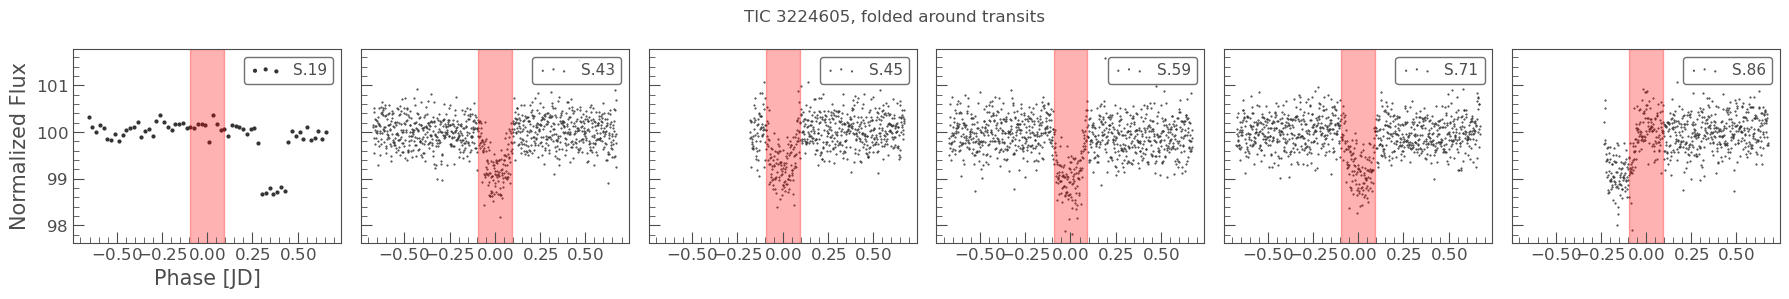

In [63]:
with plt.style.context(lk.MPLSTYLE):
    _lcc = lcc_tess[~np.isin(lcc_tess.sector, [44, 73])] # no dips in S44, S73
    fig, axs = plt.subplots(1, len(_lcc), figsize=(3 * len(_lcc), 3), sharex=True, sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(_lcc):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24 - 0.3, duration_hr_primary * 2 / 24 + 0.3)
        dot_size = 1 if lc.sector > 19 else 16
        ax = lc_f.scatter(ax=axs[i], s=dot_size, label=f"S.{lc_f.sector}");
        ax.axvspan(-duration_hr_primary * 0.5 / 24, duration_hr_primary * 0.5 / 24, color="red", alpha=0.3);
        ax.legend(loc="upper right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
        # ax.set_xlim(-0.6, 0.6)
    fig.suptitle(f"{lc.label}, folded around transits");
plt.tight_layout();

# # ---
# with plt.style.context(lk.MPLSTYLE):
#     fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
#     if isinstance(axs, plt.Axes):
#         axs = [axs]
#     for i, lc in enumerate(lcc_tess):
#         lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
#         lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
#         ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
#         ax.legend(loc="lower right");
#         if i > 0:
#             ax.set_ylabel(None)
#             ax.set_xlabel(None)
#     fig.suptitle(f"{lc.label}, folded around secondary eclipses");
# plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [52]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.0 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.0, -0.009, midpoint_p, 0.002, 1.2]
start_vals_s = None

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1824.0463999999997 -0.33412564615380164
window_width_p (phase): 0.0065153477159634165


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.009, 1824.0463999999997, 0.002, 1.2, 28.6503],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        # [0.97, -0.46, t0_primary, 0.030, 1.0, period],  # replace with the initial guess above
        nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        # nruns=1000, discard=600,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.40it/s]


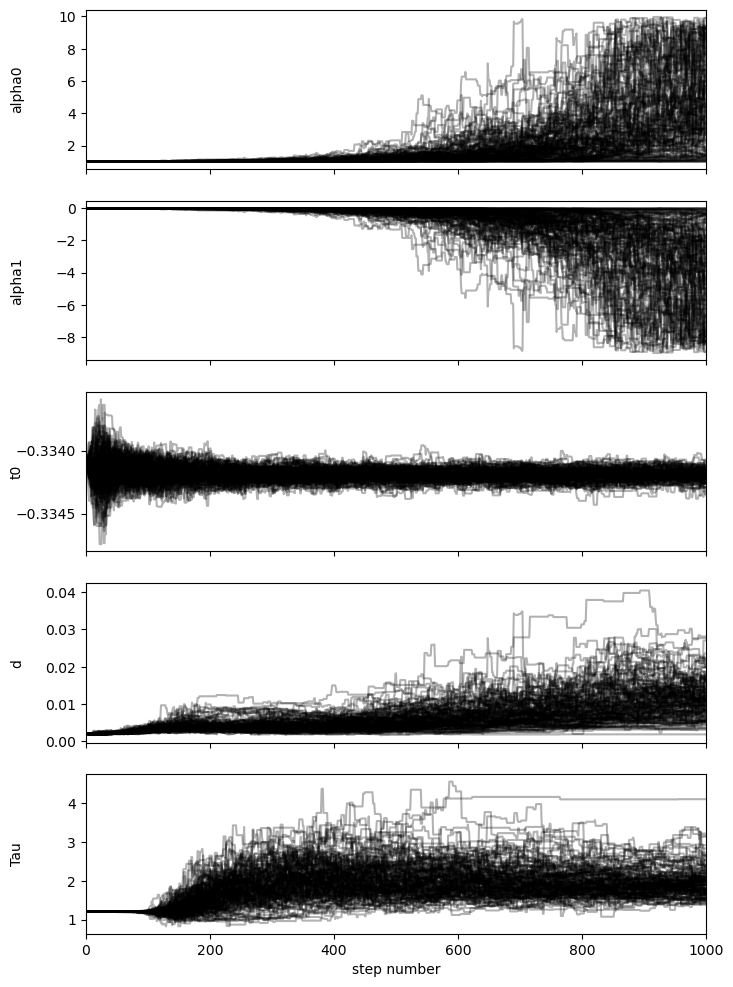

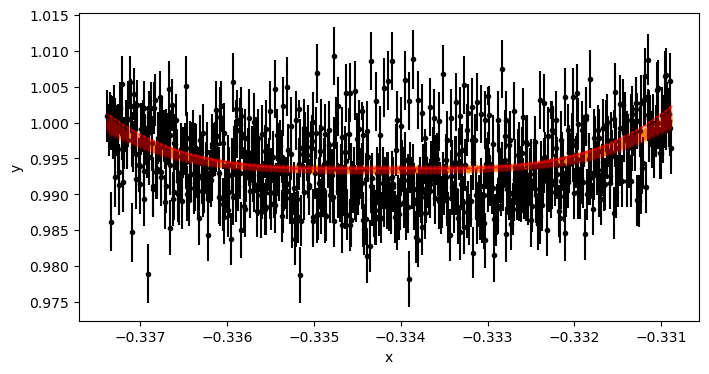

In [11]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.9595568771747205, -0.9659432901572083, -0.3341926571725454, 0.007903989890962745, 1.910983992304004
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [12]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.9595568771747205, -0.9659432901572083, -0.3341926571725454, 0.007903989890962745, 1.910983992304004


64

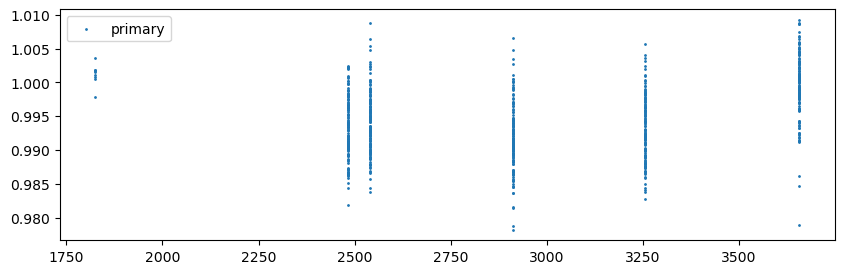

In [14]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1824.0463999999997 28.6503 1824.0463999999997


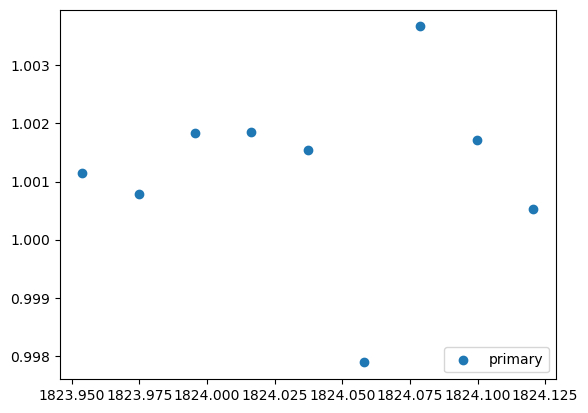

1824.0463999999997 28.6503 1852.6966999999997


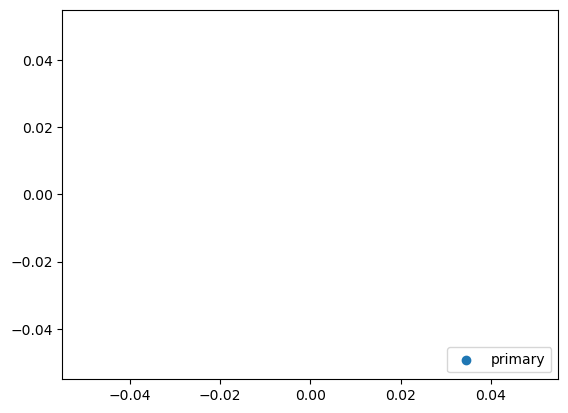

1824.0463999999997 28.6503 1881.3469999999998


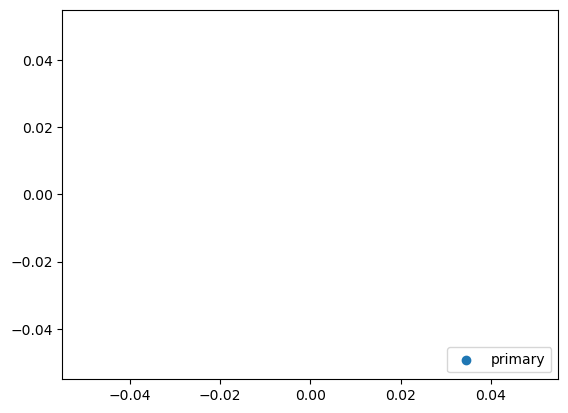

In [15]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [16]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 8


Fitting individual primary eclipses...
Creating new manifest file
1824.0463999999997 1.9595568771747205 -0.9659432901572083 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 480.03it/s]


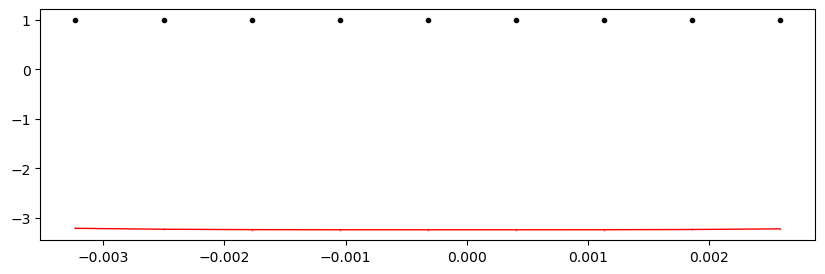

2483.0033 1.9595568771747205 -0.9659432901572083 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.47it/s]


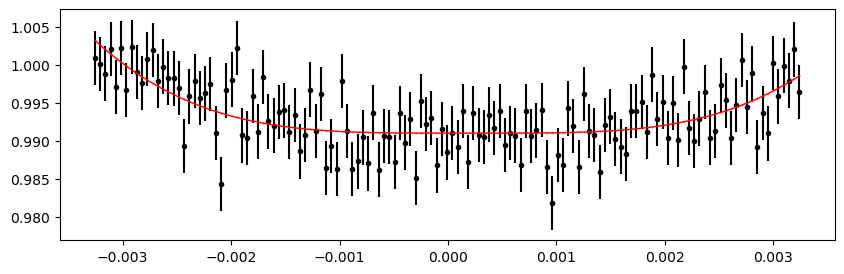

2540.3039 1.9595568771747205 -0.9659432901572083 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.87it/s]


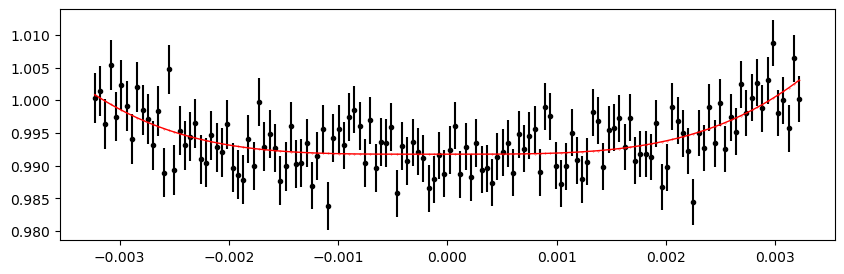

2912.7578 1.9595568771747205 -0.9659432901572083 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.81it/s]


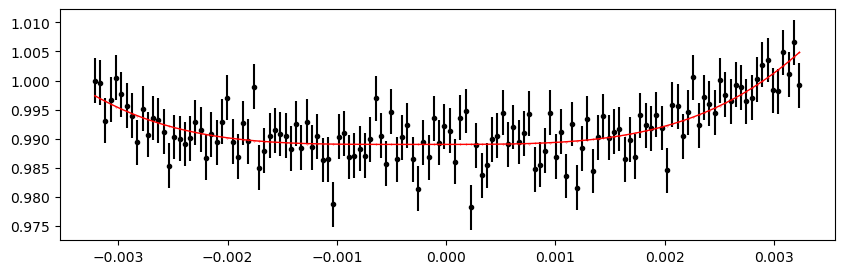

3256.5613999999996 1.9595568771747205 -0.9659432901572083 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.79it/s]


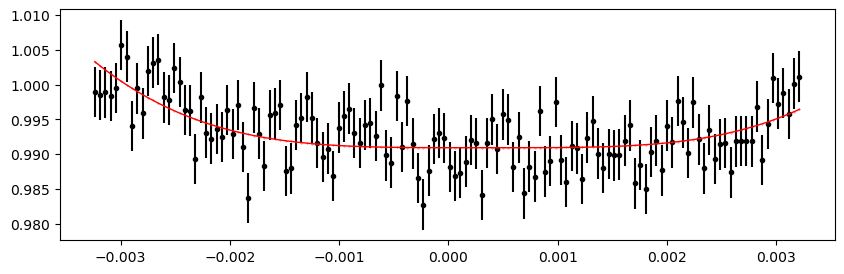

In [17]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=7,  # for 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


In [ ]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20,
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 1 data points in df_primary filtered out due to huge O-C error.


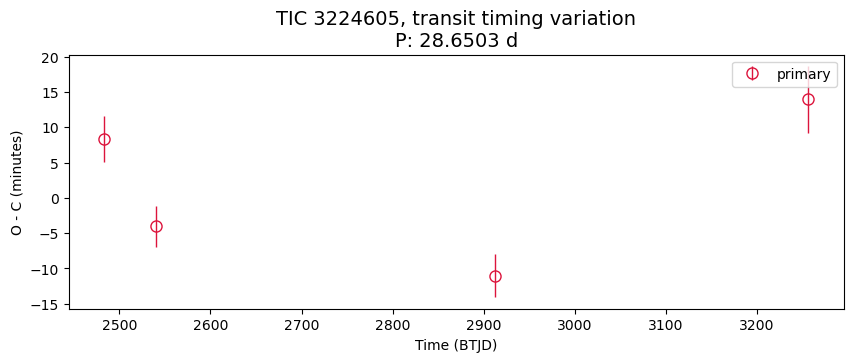

In [19]:
%matplotlib inline
# %matplotlib widget


title_suffix = "transit timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

In [53]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    # (2000, 2100),
    # (2350, 2450),
    # (2700, 2800),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
# plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if False:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [ ]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "No good period that fits all observations."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))